### Imports

In [47]:
%load_ext autoreload
%autoreload 2

from fast_style_transfer_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Restructure dataset in convenient way

In [2]:
content_path = path/'coco-images'/'test2015'
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))
content_path

PosixPath('/home/ec2-user/SageMaker/data/coco-images/test2015')

In [3]:
files = get_files(content_path, image_extensions, recurse=True); len(files)

81434

In [4]:
van_gogh_path = path/'styles'/'Kandinsky.png'; van_gogh_path

PosixPath('/home/ec2-user/SageMaker/data/styles/Kandinsky.png')

In [5]:
contents = files
styles = [van_gogh_path] * len(contents)

In [6]:
te_ = int(len(styles) * 0.001)
tr_ = len(styles) - te_
assert(len(styles) == (te_+tr_))
print(te_, tr_)
splits = ['valid'] * te_ + ['train'] * tr_ 
shuffle(splits)

81 81353


In [7]:
df = pd.DataFrame({'content_': contents, 'style_': styles, 'split_': splits}); df.head()

,content_,style_,split_
0,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/Kandinsky...,train
1,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/Kandinsky...,train
2,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/Kandinsky...,train
3,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/Kandinsky...,train
4,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/Kandinsky...,train


In [8]:
style_img = PIL.Image.open(df.sample().style_.iloc[0]); (style_img.size + (3,))

(778, 535, 3)

In [9]:
#content_img = PIL.Image.open(df.sample().content_.iloc[0]); content_img

In [10]:
df.to_csv(path/'dataset.csv', index=False)

### FastStyleTransfer

In [70]:
bs = 4
sample = 0.5
size = 300
padding = 30

rgb = MakeRGB()
resized = ResizeFixed(size)
tobyte = ToByteTensor()
tofloat = ToFloatTensor()
norm = Normalize(imagenet_stats, padding)
aug = PilRandomDihedral()

tmfs = [rgb, resized, tobyte, tofloat, norm]

train_ds = StyleTransferDataset(path/'dataset.csv', train_test='train', transform=tmfs, sample=0.02) #0.02
valid_ds = StyleTransferDataset(path/'dataset.csv', train_test='valid', transform=tmfs, sample=sample)

dataloaders = {'train': DataLoader(train_ds, batch_size=bs, shuffle=True),
              'valid': DataLoader(valid_ds, batch_size=bs)}

Valid dataset: 43 items
Item: <class 'tuple'> of 3 <class 'torch.Tensor'>
Item example: 'input':torch.Size([3, 360, 360]),'content':torch.Size([3, 360, 360]),'style':torch.Size([3, 360, 360])
Train dataset: 1626 items
Item: <class 'tuple'> of 3 <class 'torch.Tensor'>
Item example: 'input':torch.Size([3, 360, 360]),'content':torch.Size([3, 360, 360]),'style':torch.Size([3, 360, 360])
train 1572
shape of re-center-cropped image: (300, 300, 3)


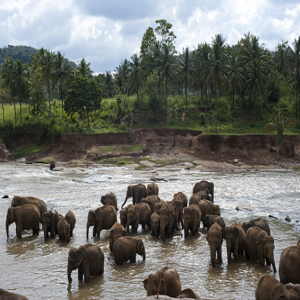

In [71]:
print(valid_ds)
print(train_ds)

datasets = {'train': train_ds, 'valid': valid_ds}
d = random.choice(['train', 'valid'])
i = random.choice(range(len(datasets[d])))
print(d, i)

test_data(dataloaders, datasets, bs, size, padding)
test_deprocess(datasets[d][i], size, padding)

In [4]:
#"block1_conv2"
#"block2_conv2"
#"block3_conv3"
#"block4_conv3"
#"block5_conv3"

In [73]:
test_hooks(TransformerNet(), dataloaders, bs)
test_losses(TransformerNet(), dataloaders)

shape of input_act:  [torch.Size([4, 64, 360, 360]), torch.Size([4, 128, 180, 180]), torch.Size([4, 256, 90, 90]), torch.Size([4, 512, 45, 45]), torch.Size([4, 512, 22, 22])]
shape of content_act:  [torch.Size([4, 64, 360, 360]), torch.Size([4, 128, 180, 180]), torch.Size([4, 256, 90, 90]), torch.Size([4, 512, 45, 45]), torch.Size([4, 512, 22, 22])]
shape of style_act:  [torch.Size([4, 64, 360, 360]), torch.Size([4, 128, 180, 180]), torch.Size([4, 256, 90, 90]), torch.Size([4, 512, 45, 45]), torch.Size([4, 512, 22, 22])]


In [6]:
# tv_weight=1, content_weight=1e3, style_weight=1e10 vgg16
# tv_weight=5e-2, content_weight=3e3, style_weight=2e10 vgg16
# tv_weight=2e-1, content_weight=4e3, style_weight=2e10, vgg=19

In [81]:
fst = FastStyleTransfer(dataloaders, *get_model_opt(TransformerNet()), tv_weight=2e-1, content_weight=4e-1, style_weight=2e10, vgg=19)

In [82]:
fst.train()


Phase: train


batch: 0: (input, content, style) = torch.Size([4, 3, 360, 360]), torch.Size([4, 3, 360, 360]), torch.Size([4, 3, 360, 360])
phase: train, loss: 39562.71340713407

Phase: valid


batch: 0: (input, content, style) = torch.Size([4, 3, 360, 360]), torch.Size([4, 3, 360, 360]), torch.Size([4, 3, 360, 360])
12m 41s



In [83]:
fst.training_done

True

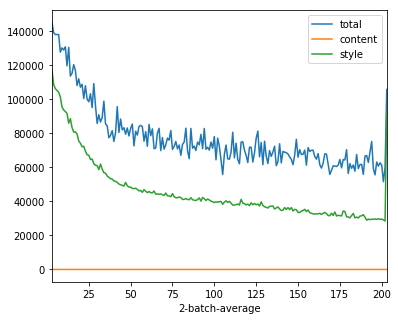

In [84]:
fst.plot_losses('train', group=2)

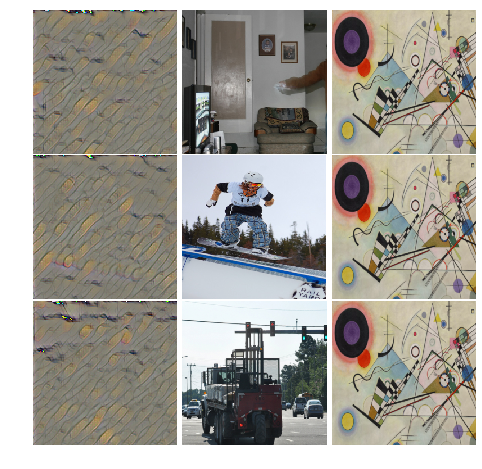

In [85]:
fst.plot_samples('train')

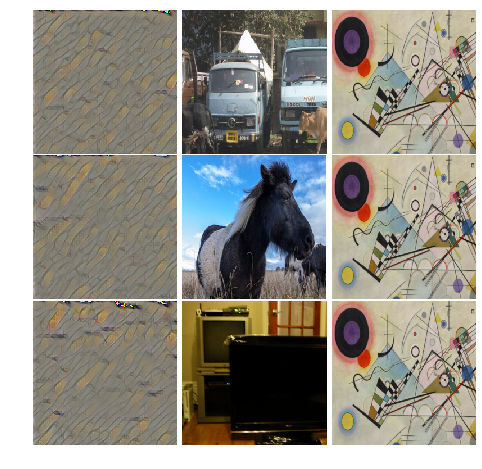

In [86]:
fst.plot_samples('valid')